In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import numpy as np

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Step 1： Read Data

In [2]:
wine = pd.read_csv('wine_data.csv',header=None,delimiter=',')

In [3]:
wine_data = wine.values

In [4]:
X_data = wine_data[:,1:]

In [5]:
X_data.shape

(178, 13)

In [6]:
Y_data = wine_data[:,0]

### Step 2: Date Preparation

##### 1） standardize data

In [7]:
Scaler = StandardScaler()

(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.60000e-01, 1.05234e+02, 2.10208e+02, 3.15182e+02, 4.20156e+02,
        5.25130e+02, 6.30104e+02, 7.35078e+02, 8.40052e+02, 9.45026e+02,
        1.05000e+03]),
 <a list of 10 Patch objects>)

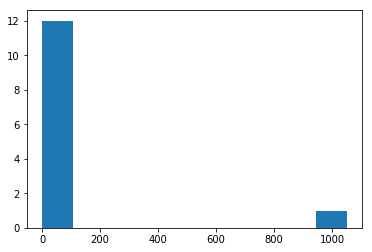

In [8]:
plt.hist(X_data[1])

In [9]:
X_data = Scaler.fit_transform(X_data)

(array([2., 1., 3., 1., 2., 0., 2., 1., 0., 1.]),
 array([-0.49840699, -0.23496952,  0.02846795,  0.29190542,  0.5553429 ,
         0.81878037,  1.08221784,  1.34565531,  1.60909279,  1.87253026,
         2.13596773]),
 <a list of 10 Patch objects>)

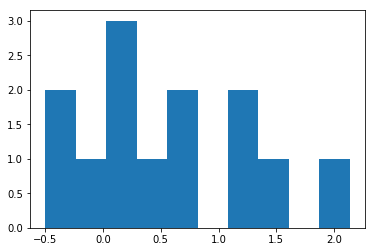

In [10]:
plt.hist(X_data[2])

#### 2) Onehot coding for target variable

In [11]:
 OH_Encoder= OneHotEncoder()

In [12]:
Y_data.shape[0]

178

In [13]:
Y_data = Y_data.reshape(Y_data.shape[0],1)

In [14]:
Y_data = OH_Encoder.fit_transform(Y_data)

In [15]:
Y_data.shape

(178, 3)

In [16]:
Y_data = Y_data.toarray()

#### 3) train test split

In [17]:
X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_data,test_size = 0.3,random_state = 3)

### Step 4: Buiding TensorFlow Deep Learning Model

In [18]:
## reset tensorflow graph
tf.reset_default_graph()

input_ph = tf.placeholder(shape=(None, 13), dtype=tf.float32)
label_ph = tf.placeholder(shape=(None, 3), dtype=tf.int64)

In [19]:

def weight_variable(shape):
    init = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(init)


def bias_variable(shape):
    init = tf.constant(0.1, shape=shape)
    return tf.Variable(init)

In [20]:

def add_variable_summaries(var):
    with tf.name_scope('summaries'):

        mean = tf.reduce_mean(var)

        tf.summary.scalar('mean', mean)
        

        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))

        tf.summary.scalar('stddev', stddev)
        

        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        

        tf.summary.histogram('histogram', var)

In [21]:
## construct the hidden layer
def hidden_layer(x, output_dim, scope='hidden_layer', act = tf.nn.relu, reuse=None):

    input_dim = x.get_shape().as_list()[-1]
    
    with tf.name_scope(scope):
        ## create weight variables
        with tf.name_scope('weight'):
            weight = weight_variable([input_dim, output_dim])
            ## add to summaries
            add_variable_summaries(weight)
            
        with tf.name_scope('bias'):
            # create bias`
            bias = bias_variable([output_dim])
            #  add to summary`
            add_variable_summaries(bias)
            
        with tf.name_scope('linear'):
            # calculate`xw+b`
            preact = tf.matmul(x, weight) + bias
            # add to histogram
            tf.summary.histogram('pre_activation', preact)
            
        # activate it
        output = act(preact)
        
        tf.summary.histogram('output', output)
        return output

In [22]:
## DNN Deep Neural network
def DNN(x, output_depths, scope='DNN_with_sums', reuse=None):
    with tf.name_scope(scope):
        net = x
        for i, output_depth in enumerate(output_depths):
            net = hidden_layer(net, output_depth, scope='hidden%d' % (i + 1), reuse=reuse)
        #  classify it
        net = hidden_layer(net,3, scope='classification', act=tf.identity, reuse=reuse)
        return net


In [23]:
dnn_with_sums = DNN(input_ph,[200, 100])

In [24]:
# 重新定义`loss`, `acc`, `train_op`
with tf.name_scope('cross_entropy'):
    loss = tf.losses.softmax_cross_entropy(logits=dnn_with_sums, onehot_labels=label_ph)
    tf.summary.scalar('cross_entropy', loss)
    
with tf.name_scope('accuracy'):
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn_with_sums, axis=-1), tf.argmax(label_ph, axis=-1)), dtype=tf.float32))
    tf.summary.scalar('accuracy', acc)

with tf.name_scope('train'):
    lr = 0.01
    optimizer = tf.train.MomentumOptimizer(learning_rate=lr,momentum=0.9)
    train_op = optimizer.minimize(loss)

<tf.Tensor 'cross_entropy/cross_entropy:0' shape=() dtype=string>

<tf.Tensor 'accuracy/accuracy:0' shape=() dtype=string>

In [25]:
### merge all variable summaries
merged = tf.summary.merge_all()

In [26]:
sess = tf.InteractiveSession()

In [27]:
train_writer = tf.summary.FileWriter('test_summary/train', sess.graph)
test_writer = tf.summary.FileWriter('test_summary/test', sess.graph)

#### training

In [28]:

sess.run(tf.global_variables_initializer())

for e in range(2000):
    sess.run(train_op, feed_dict={input_ph: X_train, label_ph: Y_train})
    if e % 100 == 99:
        # get information abour summaries, loss and accuracy
        sum_train, loss_train, acc_train = sess.run([merged, loss, acc], feed_dict={input_ph: X_train, label_ph: Y_train})
        ## write summaryies into writer
        train_writer.add_summary(sum_train, e)
        
        sum_test, loss_test, acc_test = sess.run([merged, loss, acc], feed_dict={input_ph: X_test, label_ph: Y_test})
        # 将`test`的`summaries`写入到`test_writer`中
        test_writer.add_summary(sum_test, e)
        print('STEP {}: train_loss: {:.6f} train_acc: {:.6f} test_loss: {:.6f} test_acc: {:.6f}'.format(e + 1, loss_train, acc_train, loss_test, acc_test))

# 关闭读写器
train_writer.close()
test_writer.close()

print('Train Done!')
print('-'*30)


STEP 100: train_loss: 0.014806 train_acc: 1.000000 test_loss: 0.099047 test_acc: 0.981481
STEP 200: train_loss: 0.006089 train_acc: 1.000000 test_loss: 0.094180 test_acc: 0.981481
STEP 300: train_loss: 0.003603 train_acc: 1.000000 test_loss: 0.094419 test_acc: 0.981481
STEP 400: train_loss: 0.002485 train_acc: 1.000000 test_loss: 0.095349 test_acc: 0.981481
STEP 500: train_loss: 0.001862 train_acc: 1.000000 test_loss: 0.096517 test_acc: 0.981481
STEP 600: train_loss: 0.001471 train_acc: 1.000000 test_loss: 0.097683 test_acc: 0.962963
STEP 700: train_loss: 0.001207 train_acc: 1.000000 test_loss: 0.098662 test_acc: 0.962963
STEP 800: train_loss: 0.001018 train_acc: 1.000000 test_loss: 0.099498 test_acc: 0.962963
STEP 900: train_loss: 0.000876 train_acc: 1.000000 test_loss: 0.100267 test_acc: 0.962963
STEP 1000: train_loss: 0.000767 train_acc: 1.000000 test_loss: 0.100981 test_acc: 0.962963
STEP 1100: train_loss: 0.000680 train_acc: 1.000000 test_loss: 0.101648 test_acc: 0.981481
STEP 120

under test_summary folder: command this to see the summaries visualization: $ tensorboard --logdir=train:train/,test:test/ 

In [31]:
predition_result = sess.run(dnn_with_sums,feed_dict={input_ph:X_test})

In [33]:
predictions = np.argmax(predition_result,axis = 1)

In [36]:
from sklearn.metrics import confusion_matrix,classification_report

In [37]:
confusion_matrix(y_true=np.argmax(Y_test,axis=1),y_pred=predictions)

array([[23,  0,  0],
       [ 0, 18,  1],
       [ 0,  0, 12]], dtype=int64)

In [ ]:
classification_report(y_true=Y)

In [29]:
### save the model
saver = tf.train.Saver()
saver.save(sess=sess, save_path='First_Save/wine_classification_model.ckpt', global_step=(e + 1))

'First_Save/wine_classification_model.ckpt-2000'